# OBJETIVO DO ESTUDO
## Checar se a nota média e a receita de um filme podem ser explicadas/preditas atraves de um modelo de regressão linear simples/múltipla

## Importando Bibliotecas

In [255]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sqlite3
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_breuschpagan, lilliefors
from statsmodels.stats.outliers_influence import variance_inflation_factor



## Carregando o Dataset

Carregando dataset "movies" do arquivo movies.db


Há 3 mil filmes no banco de dados, todos obtidos através da API do The Movie Database (TMDB) -> https://api.themoviedb.org

Carregando apenas os filmes com informações sobre renda (revenue) e orçamento (budget)

In [306]:
conn = sqlite3.connect('movies.db')
df = pd.read_sql_query("SELECT * FROM movies WHERE revenue > 0 AND budget >0  ", conn)
conn.close()
df.head(10)
print("Checando o tipo dos dados")
print(df.dtypes)
print("Checando se há dados nulos")
print(df.isnull().sum())
print("Checando se há dados zerados")
print((df == 0).sum())
print("Checando o shape do dataframe")
print(df.shape)

Checando o tipo dos dados
id                int64
title               str
release_date        str
runtime           int64
budget            int64
revenue           int64
vote_average    float64
popularity      float64
vote_count        int64
dtype: object
Checando se há dados nulos
id              0
title           0
release_date    0
runtime         0
budget          0
revenue         0
vote_average    0
popularity      0
vote_count      0
dtype: int64
Checando se há dados zerados
id              0
title           0
release_date    0
runtime         0
budget          0
revenue         0
vote_average    2
popularity      0
vote_count      2
dtype: int64
Checando o shape do dataframe
(1035, 9)


In [127]:
numeric_cols = df.select_dtypes(include='number')
# Convertendo para base logarítmica devido a escala.
numeric_cols['log_budget'] = np.log1p(numeric_cols['budget'])
numeric_cols['log_revenue'] = np.log1p(numeric_cols['revenue'])
numeric_cols.drop(columns=["id","budget","revenue"], inplace=True)
numeric_cols.describe()

,runtime,vote_average,popularity,vote_count,log_budget,log_revenue
count,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000,1035.000000
mean,118.285024,7.006323,13.078067,6971.466667,17.204021,18.152931
std,24.044143,0.870575,19.196733,6837.762373,1.663368,2.350729
min,3.000000,0.000000,6.851500,0.000000,1.609438,1.791759
25%,101.000000,6.518000,7.747600,1230.500000,16.380460,17.069746
50%,115.000000,7.057000,9.179900,5153.000000,17.453097,18.762623
75%,131.000000,7.597500,12.060400,10562.000000,18.420681,19.832376
max,229.000000,10.000000,370.855000,38779.000000,20.185240,21.796118


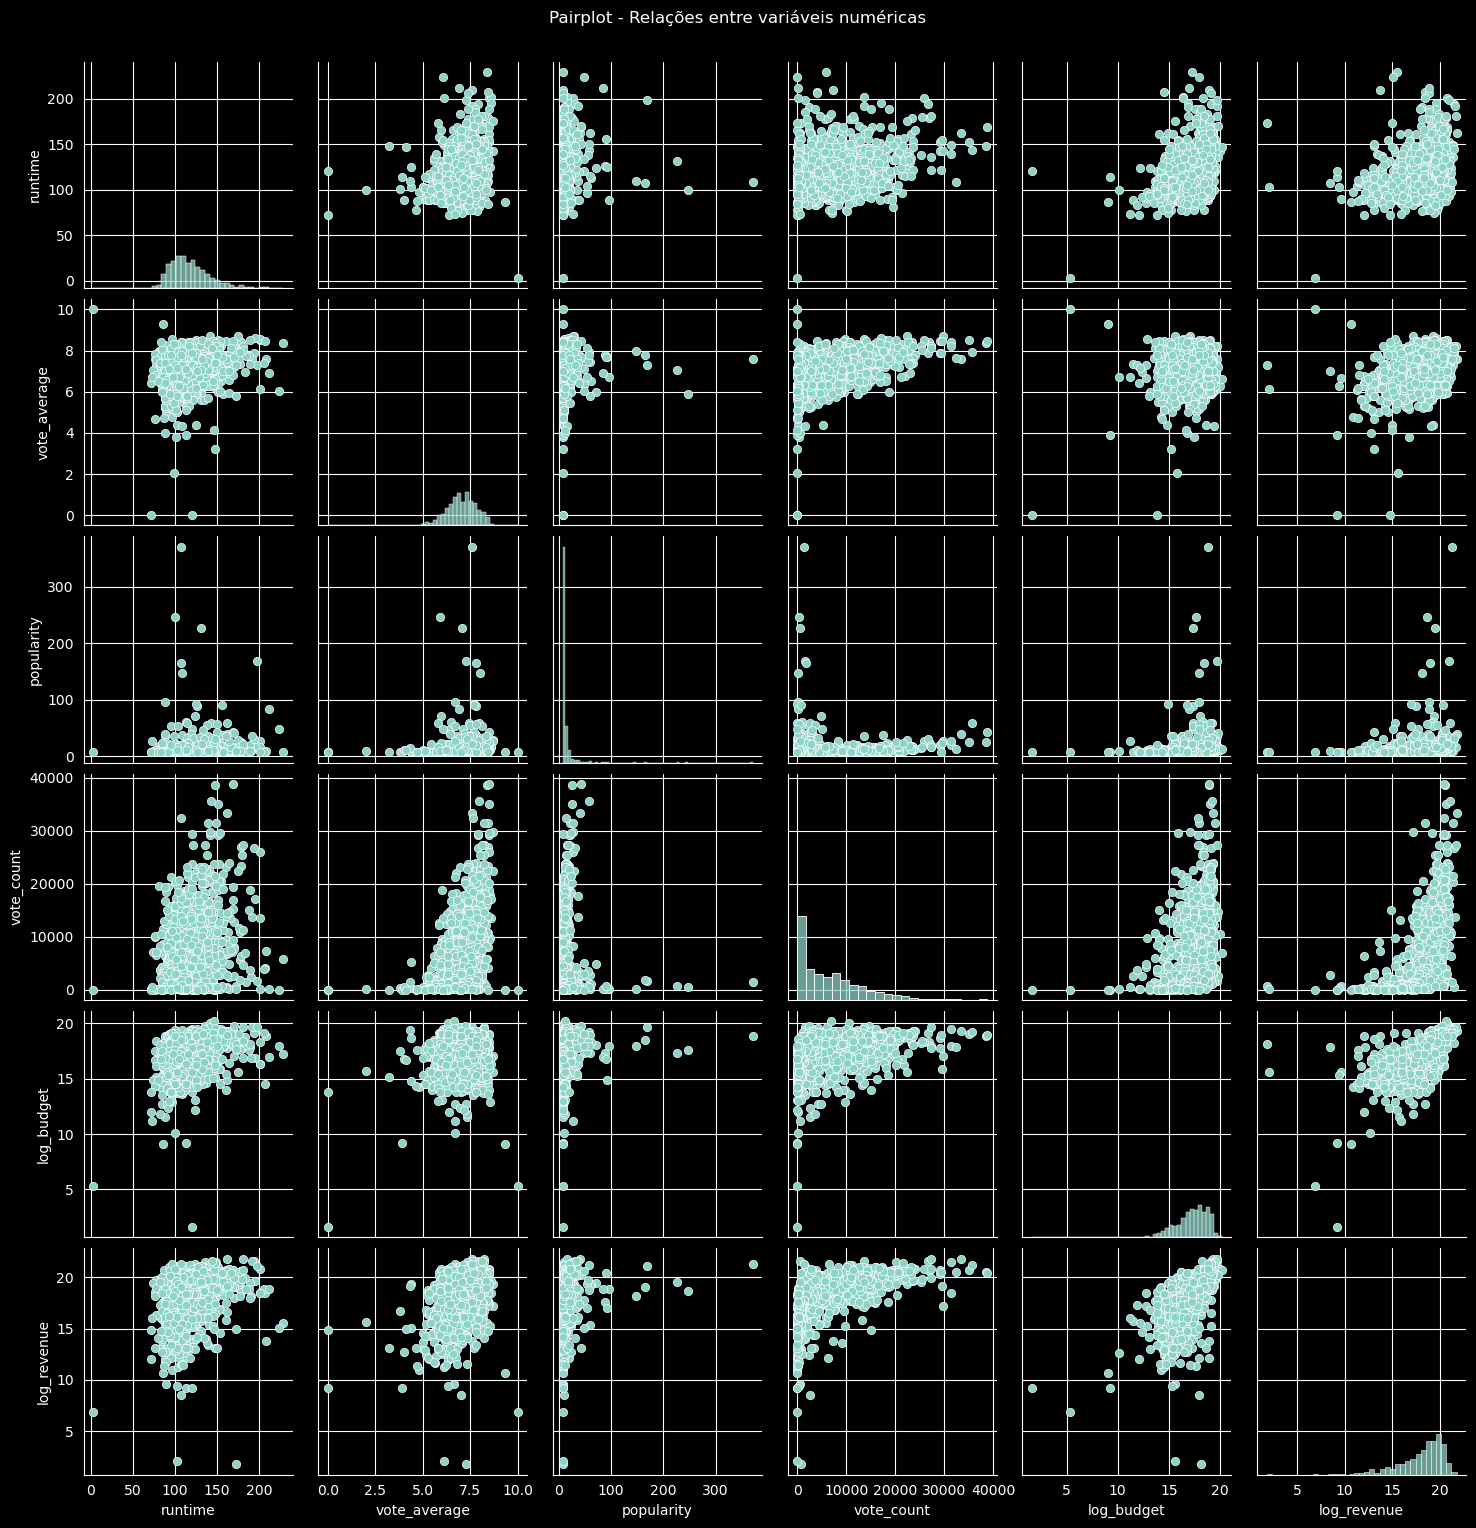

In [128]:
sns.pairplot(numeric_cols)
plt.suptitle("Pairplot - Relações entre variáveis numéricas", y=1.02)
plt.show()

## Análise gráfica (histograma) das variaveis independentes e Teste de normalidade (Shapiro-Wilk)

In [ ]:
numeric_cols[["runtime","vote_average", "popularity", "vote_count","log_budget", "log_revenue"]].hist(figsize=(20,8), bins=50)

In [129]:
for col in numeric_cols:
    stat,p = stats.shapiro(numeric_cols[col])
    print(f"{col}: stat={stat:.4f}, p={p:.4f}")

runtime: stat=0.9419, p=0.0000
vote_average: stat=0.9211, p=0.0000
popularity: stat=0.2494, p=0.0000
vote_count: stat=0.8723, p=0.0000
log_budget: stat=0.8884, p=0.0000
log_revenue: stat=0.8766, p=0.0000


Com o valor de p<0.05 podemos rejeitar a hipótese nula (os dados não são normalmente distribuidos)

## Cálculo da correlação

Aplicando a correlação de spearman para detectar correlações moderadas/fortes entre os dados quantitativos

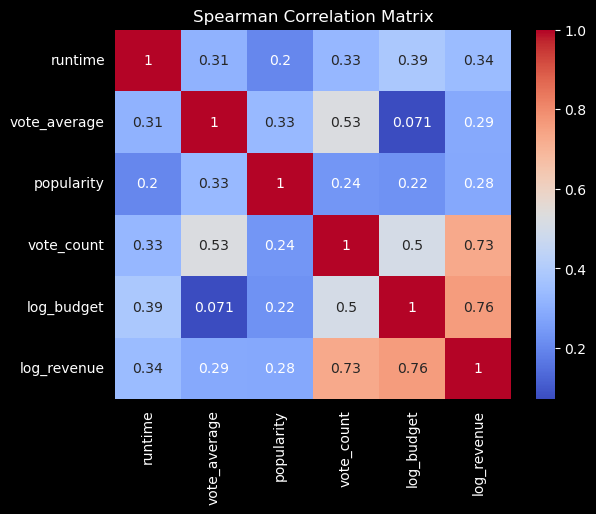

In [130]:
corr_spearman = numeric_cols.corr(method='spearman')
sns.heatmap(corr_spearman,annot=True, cmap='coolwarm')
plt.title('Spearman Correlation Matrix')
plt.show()

In [131]:
def list_significant_correlations():
    mask  = np.triu( np.ones_like(corr_spearman, dtype=bool) )
    #print(np.shape(corr_spearman.mask(mask).unstack()) )
    df = corr_spearman.mask(mask).unstack().dropna()
    filter = df[abs(df) >=0.5]
    tuple_list_corr = [ (index, round(value,4)) for index, value in filter.items()]
    tuple_list_corr = sorted(tuple_list_corr, key=lambda x: x[1], reverse=True)
    print("Lista de correlações fortes/moderadas")
    for par,value in tuple_list_corr:
        print(f"{par[0]} e {par[1]} : {value}")

list_significant_correlations()

Lista de correlações fortes/moderadas
log_budget e log_revenue : 0.7633
vote_count e log_revenue : 0.7313
vote_average e vote_count : 0.5282
vote_count e log_budget : 0.5041


In [132]:
print("\nTeste de Hipótese - Correlação entre revenue e budget")
r,p_value = stats.spearmanr(numeric_cols['log_revenue'], numeric_cols['log_budget'])
print(f"r = {r:.4f} / p = {p_value:.4f}")
print("\nTeste de Hipótese - Correlação entre revenue e vote_average")
r,p_value = stats.spearmanr(numeric_cols['log_revenue'], numeric_cols['vote_average'])
print(f"r = {r:.4f} / p = {p_value:.4f}")
print("\nTeste de Hipótese - Correlação entre revenue e runtime")
r,p_value = stats.spearmanr(numeric_cols['log_revenue'], numeric_cols['runtime'])
print(f"r = {r:.4f} / p = {p_value:.4f}")



Teste de Hipótese - Correlação entre revenue e budget
r = 0.7633 / p = 0.0000

Teste de Hipótese - Correlação entre revenue e vote_average
r = 0.2851 / p = 0.0000

Teste de Hipótese - Correlação entre revenue e runtime
r = 0.3429 / p = 0.0000


Os testes de hipótese (Correlação de Spearman) indicam que todas as variáveis testadas possuem uma relação estatisticamente significativa com a receita, dado que todos os p-valores foram inferiores a $0,05$ ($p = 0,0000$), permitindo rejeitar a hipótese nula de ausência de relação. No entanto, a intensidade dessa relação varia significativamente: o **budget** apresenta uma correlação forte ($r = 0,76$), enquanto o **vote_average** e o **runtime** possuem correlações positivas, porém fracas.

## Modelo de regressão

In [133]:
#Variaveis independentes
X_budget = numeric_cols['log_budget']
X_vote_average = numeric_cols['vote_average']
X_runtime = numeric_cols['runtime']

#Variável dependente
y= numeric_cols['log_revenue']

# Adicionando uma constante à variável independente
X_budget = sm.add_constant(X_budget)
X_vote_average = sm.add_constant(X_vote_average)
X_runtime = sm.add_constant(X_runtime)

# Ajustando o modelo de regressão linear
budget_model = sm.OLS(y, X_budget).fit()
vote_average_model = sm.OLS(y, X_vote_average).fit()
runtime_model = sm.OLS(y, X_runtime).fit()

# Sumário do modelo
budget_model_summary = budget_model.summary()
vote_average_model_summary = vote_average_model.summary()
runtime_model_summary = runtime_model.summary()

print("***Budget model summary:***\n\n", budget_model_summary)

print("\n\n\n***Vote average model summary:***\n\n",vote_average_model_summary)

print("***\n\n\nRuntime model summary:***\n\n",runtime_model_summary)


***Budget model summary:***

                             OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     861.4
Date:                Wed, 04 Feb 2026   Prob (F-statistic):          3.42e-138
Time:                        16:49:54   Log-Likelihood:                -2038.9
No. Observations:                1035   AIC:                             4082.
Df Residuals:                    1033   BIC:                             4092.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7579 

A análise dos modelos de regressão linear simples revela que, embora todos os preditores testados possuam significância estatística — com a probabilidade da estatística F e os p-valores dos coeficientes inferiores a 0,05  —, eles diferem drasticamente em sua capacidade preditiva. O modelo baseado no orçamento (budget_model) destaca-se como o mais robusto,
 apesar de explicar apenas 45,5% da variabilidade da receita ($R^2 = 0,455$). Em contrapartida, os modelos de avaliação do público ($R^2 = 0,115$) e duração ($R^2 = 0,083$), apesar de apresentarem relações reais, explicam uma parcela muito pequena do sucesso financeiro.

## Análise de resíduos - Conformidade com as premissas da Regressão Linear

### Testando a Homocedasticidade dos resíduos

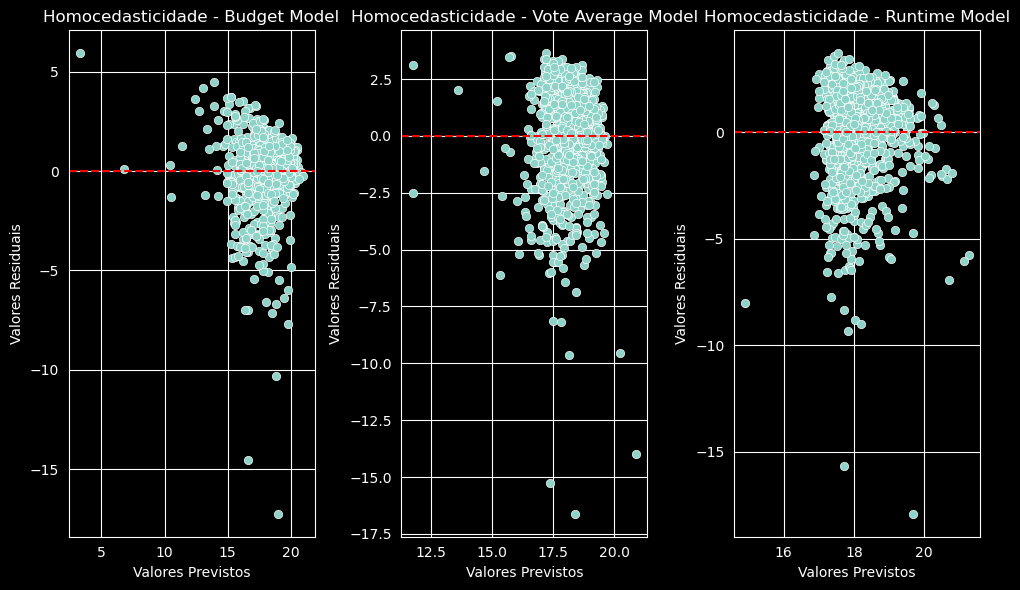

In [134]:
#Resíduos
budget_residuals = budget_model.resid
vote_average_residuals = vote_average_model.resid
runtime_residuals = runtime_model.resid


# Gráfico de homocedasticidade
plt.figure(figsize=(10,6))

plt.subplot(1,3,1)
sns.scatterplot(x=budget_model.fittedvalues,y=budget_residuals)
plt.axhline(y=0,color='red', linestyle='--')
plt.title('Homocedasticidade - Budget Model')
plt.xlabel("Valores Previstos")
plt.ylabel("Valores Residuais")

plt.subplot(1,3,2)
sns.scatterplot(x=vote_average_model.fittedvalues, y=vote_average_residuals)
plt.axhline(y=0,color='red', linestyle='--')
plt.title('Homocedasticidade - Vote Average Model')
plt.xlabel("Valores Previstos")
plt.ylabel("Valores Residuais")

plt.subplot(1,3,3)
sns.scatterplot(x=runtime_model.fittedvalues, y=runtime_residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Homocedasticidade - Runtime Model')
plt.xlabel("Valores Previstos")
plt.ylabel("Valores Residuais")


plt.tight_layout()
plt.show()

#### **Teste de Homocedasticidade com Breusch-Pagan**

**Hipótese Nula** ($H_0$): Os resíduos são Homocedásticos (a variância é constante).

**Hipótese Alternativa** ($H_a$): Os resíduos são Heterocedásticos (a variância muda conforme o valor da variável independente)

* Se o **p-valor for menor que 0.05**, podemos descartar a hiṕótese nula, ou seja, os resíduos seriam **heterocedásticos**

In [146]:
models = [
    ("budget_model", budget_model, X_budget ),
    ("vote_average_model", vote_average_model, X_vote_average),
    ("runtime_model", runtime_model, X_runtime),
]

for name, model, data in models:
    _, p_value, _, fp_value = het_breuschpagan(model.resid, model.model.exog)
    print(f"Estatísticas para o {name}\n")
    print(f"p-value = {p_value:.4f}")
    print(f"f-value = {fp_value:.4f}")

Estatísticas para o budget_model

p-value = 0.0007
f-value = 0.0007
Estatísticas para o vote_average_model

p-value = 0.1834
f-value = 0.1837
Estatísticas para o runtime_model

p-value = 0.3598
f-value = 0.3603



Após a análise dos gráficos e da realização do teste de Breusch-Pagan, pode-se concluir que há heterocedasticidade no budget_model, violando uma das premissas da Regressão Linear, porém tanto o vote_average_model e o runtime_model apresentam homocedasticidade.

### Testando a normalidade dos resíduos

#### Teste de Shapiro-Wilk

**Hipótese Nula** ($H_0$): Os resíduos segue uma distribuição normal.

**Hipótese Alternativa** ($H_a$): Os resíduos não seguem uma distribuição normal

* Se o **p-valor for menor que 0.05**, podemos descartar a hiṕótese nula, ou seja, os resíduos não seguiriam uma **distribuição normal**

In [275]:
for name, model, data in models:
    statistic, p_value_shapiro = stats.shapiro(model.resid)
    print(f"Estásticas para o {name}")
    print(f'Estatística de teste = {statistic:.4f}')
    print(f"p-value = {p_value_shapiro:.4f}\n")

Estásticas para o budget_model
Estatística de teste = 0.8309
p-value = 0.0000

Estásticas para o vote_average_model
Estatística de teste = 0.8927
p-value = 0.0000

Estásticas para o runtime_model
Estatística de teste = 0.8805
p-value = 0.0000



##### **Análise gráfica**

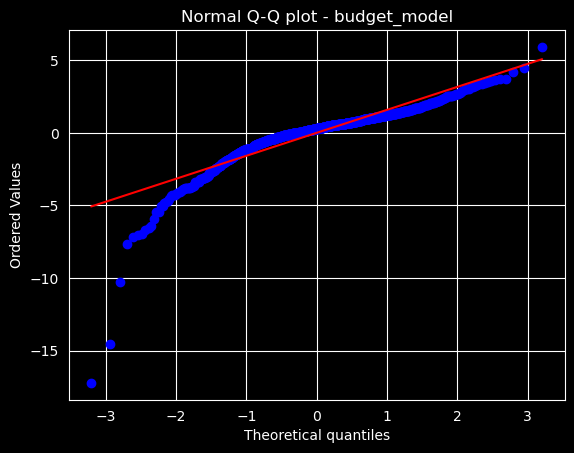

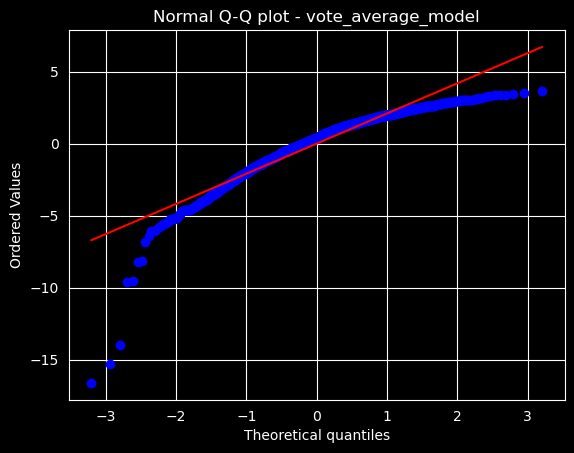

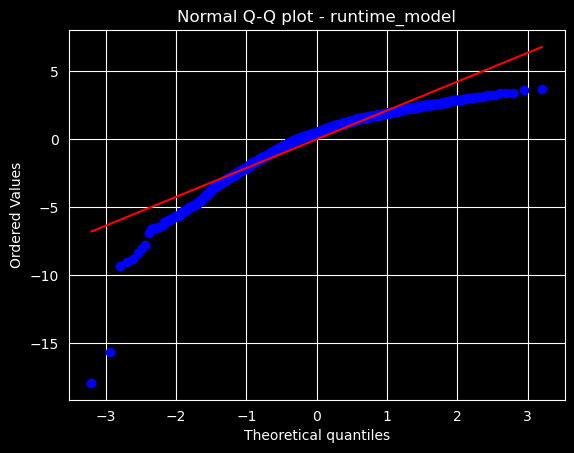

In [150]:
for name, model, data in models:
    stats.probplot(model.resid, dist='norm', plot=plt)
    plt.title(f"Normal Q-Q plot - {name}")
    plt.show()

Feita a análise da normalidade de resíduos, podemos concluir que **eles não seguem uma distribuição normal**, o que contraria uma das premissas da Regressão Linear

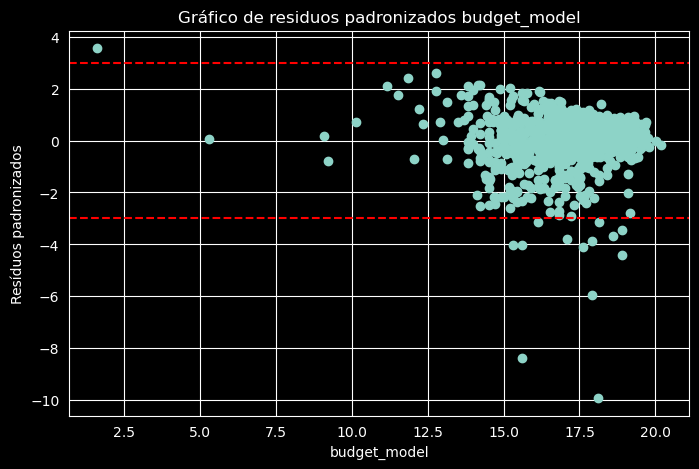

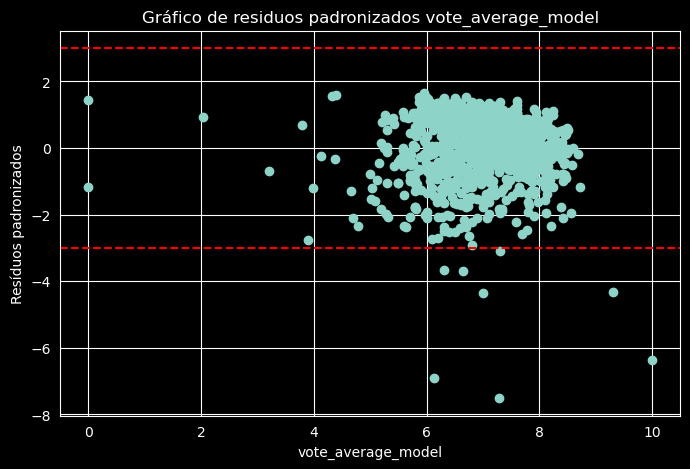

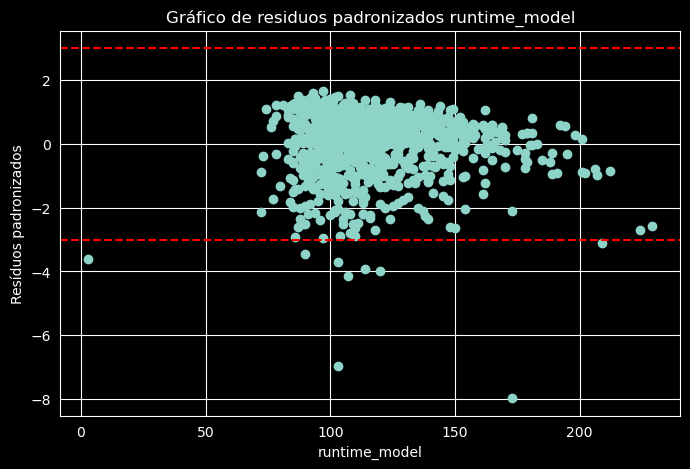

In [163]:
for name, model, data in models:
    standardized_residuals = model.get_influence().resid_studentized_internal
    plt.figure(figsize=(8,5))
    plt.scatter(data.iloc[:,1], standardized_residuals)
    plt.axhline(y=3, color="red", linestyle="--")
    plt.axhline(y=-3, color="red", linestyle="--")
    plt.title(f'Gráfico de residuos padronizados {name}')
    plt.ylabel("Resíduos padronizados")
    plt.xlabel(name)
    plt.show()

Apesar de a maioria dos pontos estarem detro dos limites de -3, +3 ( 68-95-99.7 rule), tanto o teste de Shapiro-Wilk quanto o Q-Q plot, indicam
a não normalidade dos resíduos.

## Gráfico dos Modelos Ajustados

Apesar de pouco se diferenciar de um gráfico de dispersão comum, estamos utilizando o gráfico CCPR para, posteriormente, comparar com os resultados de um modelo de regressão linear múltipla.

Budget model


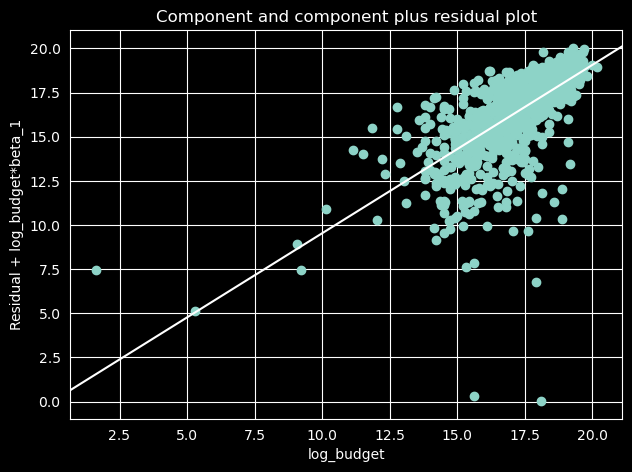

In [185]:
print("Budget model")
fig = sm.graphics.plot_ccpr(budget_model,"log_budget")
fig.tight_layout(pad=1.0)


Vote average model


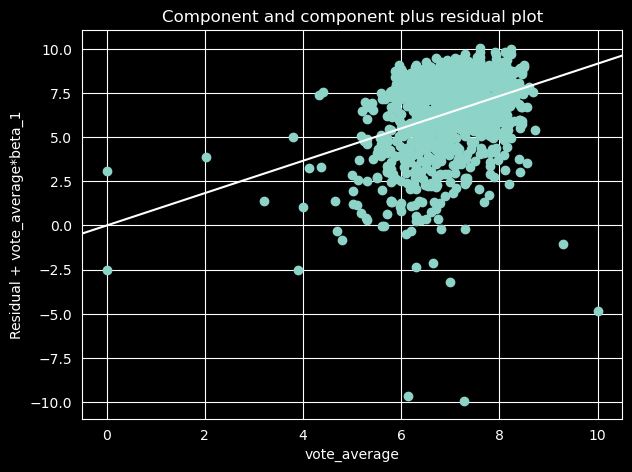

In [186]:
print("Vote average model")
fig = sm.graphics.plot_ccpr(vote_average_model,"vote_average")
fig.tight_layout(pad=1.0)

Runtime model


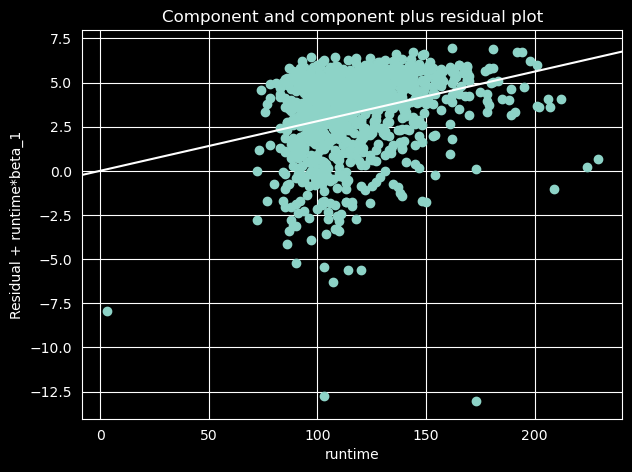

In [187]:
print("Runtime model")
fig = sm.graphics.plot_ccpr(runtime_model,"runtime")
fig.tight_layout(pad=1.0)

# REGRESSÃO LINEAR MÚLTIPLA

##### Construindo o modelo utilizando smf e apresentado o resumo do seu desempenho

In [257]:
model_mult_1 = smf.ols('log_revenue ~ runtime + vote_average + popularity + vote_count + log_budget', data = numeric_cols).fit()
model_mult_1.summary(title="Sumário do primeiro modelo de Regressão Linear Múltipla")

<class 'statsmodels.iolib.summary.Summary'>
"""
           Sumário do primeiro modelo de Regressão Linear Múltipla            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     280.1
Date:                Fri, 06 Feb 2026   Prob (F-statistic):          4.23e-189
Time:                        13:55:29   Log-Likelihood:                -1908.2
No. Observations:                1035   AIC:                             3828.
Df Residuals:                    1029   BIC:                             3858.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.4898      0.689      3.613      0.000       1.137       3.842
runtime         -0.0045      0.002     -2.041      0.042      -0.009      -0.000
vote_average     0.3116      0.064      4.870      0.000       0.186       0.437
popularity       0.0059      0.003      2.341      0.019       0.001       0.011
vote_count       0.0001   8.73e-06     12.367      0.000    9.08e-05       0.000
log_budget       0.7663      0.033     23.355      0.000       0.702       0.831
==============================================================================
Omnibus:                      733.428   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21035.406
Skew:                          -2.866   Prob(JB):                         0.00
Kurtosis:                      24.329   Cond. No.                     1.41e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


##### Ajustando o problema: The condition number is large, 1.41e+05. This might indicate that there are strong multicollinearity or other numerical problems.

##### Provavel causa são as escalas destoantes das variaveis independentes.

In [308]:

from sklearn.preprocessing import StandardScaler
X = numeric_cols
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
model_mult_2 = smf.ols('log_revenue ~ runtime + vote_average + popularity + vote_count + log_budget', data = X_scaled_df).fit()
model_mult_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     280.1
Date:                Fri, 06 Feb 2026   Prob (F-statistic):          4.23e-189
Time:                        15:29:27   Log-Likelihood:                -1024.0
No. Observations:                1035   AIC:                             2060.
Df Residuals:                    1029   BIC:                             2090.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -8.123e-16      0.020     -4e-14      1.000      -0.040       0.040
runtime         -0.0462      0.023     -2.041      0.042      -0.091      -0.002
vote_average     0.1154      0.024      4.870      0.000       0.069       0.162
popularity       0.0483      0.021      2.341      0.019       0.008       0.089
vote_count       0.3139      0.025     12.367      0.000       0.264       0.364
log_budget       0.5423      0.023     23.355      0.000       0.497       0.588
==============================================================================
Omnibus:                      733.428   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21035.406
Skew:                          -2.866   Prob(JB):                         0.00
Kurtosis:                      24.329   Cond. No.                         2.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A análise do modelo de regressão linear múltipla revela que o modelo é significativo, assim como todos seus preditores, dado o p-valor da estatística F e os p-valores dos coeficientes < 0.05, porém a sua capacidade de explicar a variabilidade do variavel dependente revenue é moderada ($R^2 = 0,574$).

### Verificando a presença de Multicolinearidade

Somente entre as variáveis **independentes**.
- Atenção a valores com r > 0,7
- Considerada multicolinearidade quando r > 0.9.

In [ ]:
X_scaled_df.corr()

Usando Fator de Inflação de Variância (VIF)

- VIFs > 10 indicam alta multicolinearidade
- VIFs >=5 e <= 10 podem ser preocupantes

In [ ]:
from statsmodels.tools.tools import add_constant
vif  = sm.add_constant(X_scaled_df)
pd.Series([variance_inflation_factor(vif.values, j) for j in range(vif.shape[1])], index=vif.columns)

Os valores do Fator de Inflação de Variância **não indicaram multicolinearidade**

### Análise Gráfica dos Resíduos

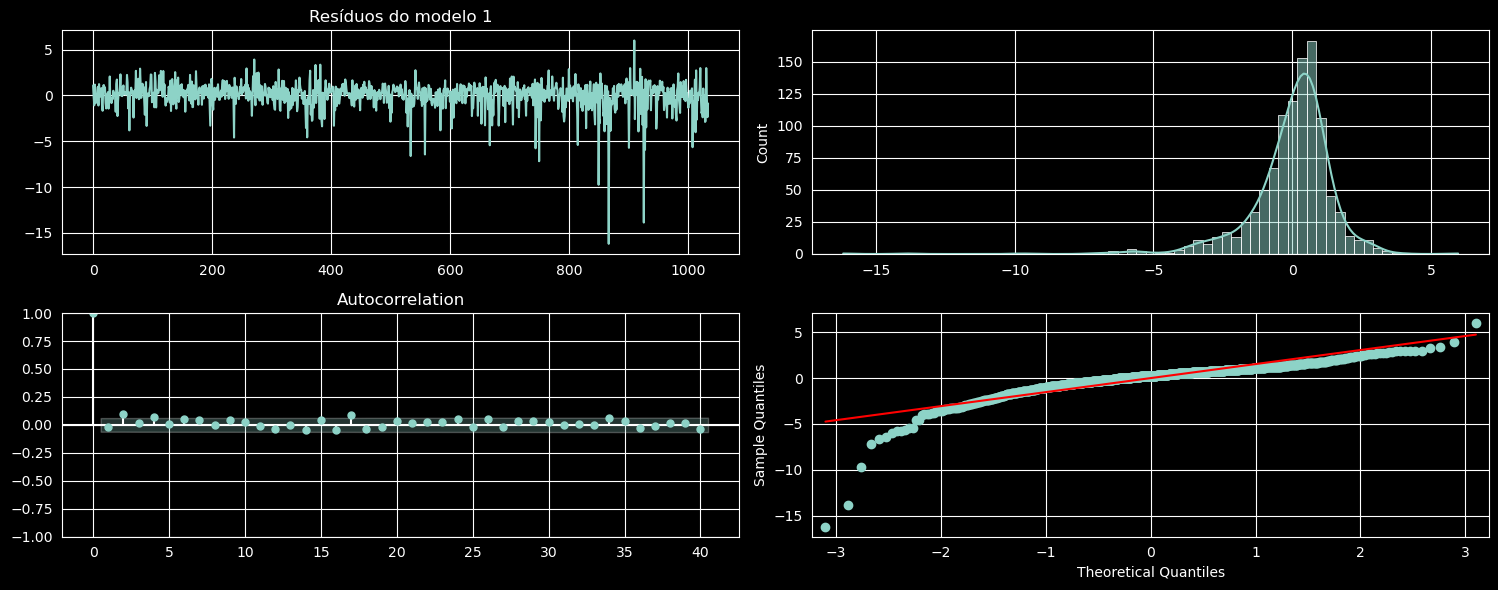

In [295]:
residuals_model_mult_2= model_mult_2.resid
fig, ax = plt.subplots(2,2, figsize=(15,6))
residuals_model_mult_2.plot(title="Resíduos do modelo 1", ax=ax[0][0])
sns.histplot(residuals_model_mult_2, ax= ax[0][1], kde=True, )
plot_acf(residuals_model_mult_2, lags=40, ax=ax[1][0]);
qqplot(residuals_model_mult_2,line="s", ax=ax[1][1]);

plt.tight_layout()

### Teste de Normalidade dos resíduos

In [261]:
statistic, p = stats.shapiro(model_mult_2.resid)
print(f'Estatística de teste: {statistic:.4f}')
print(f'p-valor: {p:.4f}')

Estatística de teste: 0.8186
p-valor: 0.0000


p-valor menor que 0.05 indicando que os residuos **não seguem a distribuição normal**

### Análise da Homocedasticidade dos resíduos

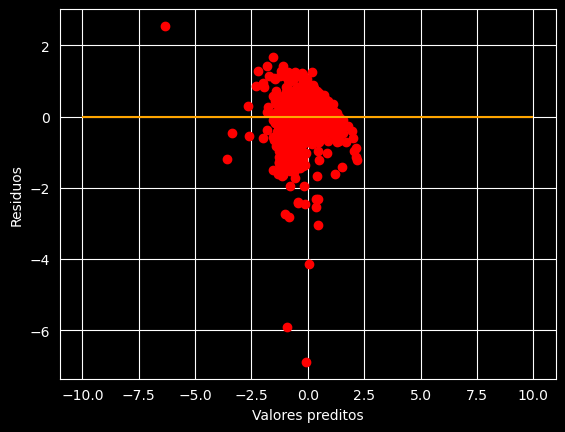

In [278]:
plt.scatter(y=model_mult_2.resid, x=model_mult_2.predict(), color='red')
plt.hlines(y=0, xmin = -10, xmax=10, color='orange')
plt.ylabel('Residuos')
plt.xlabel('Valores preditos')
plt.show()

In [279]:
_, p, _, fp = het_breuschpagan(model_mult_2.resid, model_mult_2.model.exog)
print(f'p-valor da estatística F: {fp:.4f}')
print(f'p-valor: {p:.4f}')


p-valor da estatística F: 0.0012
p-valor: 0.0013


Valores obtidos pelo Teste Breusch-Pagan confirmar a **heterocedasticidade dos resíduos**

### Análise gráfica do impacto de cada preditora no modelo

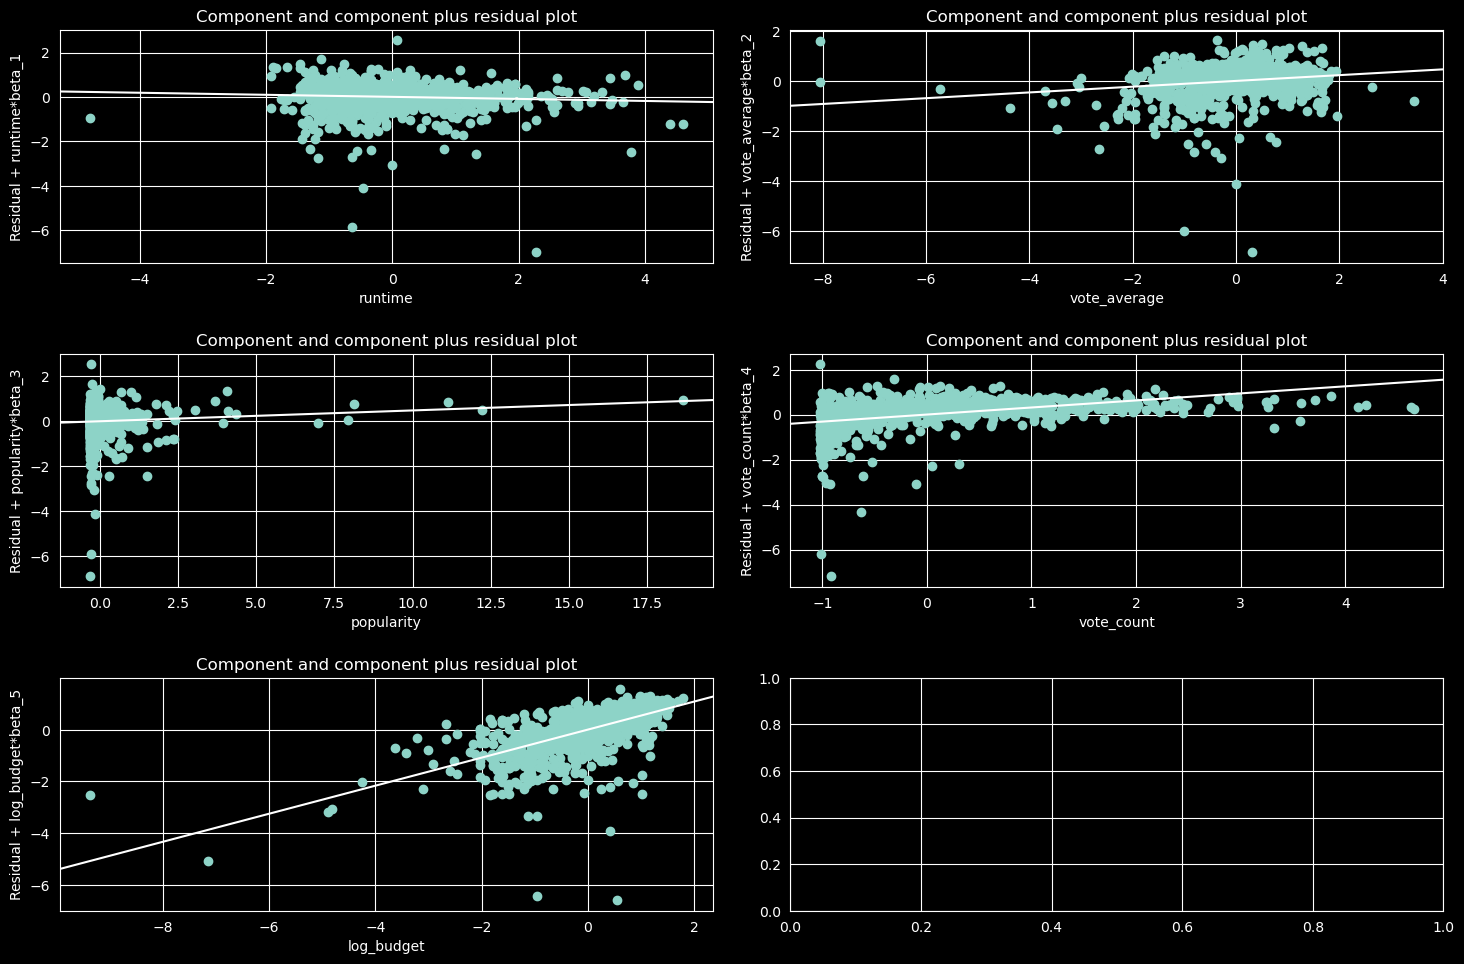

In [309]:
fig, ax = plt.subplots(3,2, figsize=(15,10))
sm.graphics.plot_ccpr(model_mult_2, "runtime", ax[0][0])
sm.graphics.plot_ccpr(model_mult_2, "vote_average", ax[0][1])
sm.graphics.plot_ccpr(model_mult_2, "popularity", ax[1][0])
sm.graphics.plot_ccpr(model_mult_2, "vote_count", ax[1][1])
sm.graphics.plot_ccpr(model_mult_2, "log_budget", ax[2][0])
plt.tight_layout(pad=2.0)
plt.show()

Eliminando as variáveis **runtime** e **popularity** para comparar o desempenho do modelo

In [314]:
model_mult_3 = smf.ols('log_revenue ~ vote_average + vote_count + log_budget', data = X_scaled_df).fit()

#Comparação dos modelos
print(model_mult_2.summary(title='Modelo com todas variáveis'))
print("*****\n\n*****")
print(model_mult_3.summary(title='Modelo sem runtime e popularity'))

                          Modelo com todas variáveis                          
Dep. Variable:            log_revenue   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     280.1
Date:                Fri, 06 Feb 2026   Prob (F-statistic):          4.23e-189
Time:                        15:47:45   Log-Likelihood:                -1024.0
No. Observations:                1035   AIC:                             2060.
Df Residuals:                    1029   BIC:                             2090.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -8.123e-16      0.020     -4e-14   

Após a análise tanto dos modelos de regressão linear simples quanto o modelo regressão múltipla, fica evidente que a variavel preditora mais influente na renda(revenue) é o budget (orçamento). A média (vote_average) e o número de votos (vote_count) também mostram uma influencia moderada, porém menores que o orçamento.
Tendo em vista que as premissas da regressão liner não foram devidamente atendidas, modelos de regressão linear não aparentam ser a melhor estrategia para prever a renda de filmes.